In [145]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from collections import Counter
from sklearn import tree
from sklearn import metrics

In [7]:
data = pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [9]:
data.head()

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
0,0,1090,43,66.679,0,1,0,100,0,1,...,1,1,3,0,504,353,660,1,870,782
1,1,794,31,73.030,0,1,0,100,0,1,...,1,1,3,0,244,225,106,1,708,699
2,0,957,41,66.226,0,1,1,100,0,1,...,1,1,3,0,401,366,453,1,889,720
3,1,188,35,78.019,0,1,0,100,0,1,...,1,1,3,0,221,132,-1,0,221,759
4,1,308,40,83.009,0,1,0,100,0,1,...,1,1,3,1,150,90,20,1,1730,1160


In [12]:
data['censor'].value_counts()

censor
0    351
1    181
Name: count, dtype: int64

In [13]:
Y = data['censor']
X = data.drop(columns=['censor'])

In [24]:
SKFold = StratifiedKFold(n_splits=5, shuffle=True)

In [39]:
train_idx = []
valid_idx = []
data_split = SKFold.split(X, Y)
data_split=next(data_split)
train_idx = data_split[0]
valid_idx = data_split[1]

In [93]:
for i in range(2,11,1):
    print(">>>> Depth {}".format(i))

    model = DecisionTreeClassifier(max_depth=i, criterion='gini', random_state=0)
    model.fit(X.iloc[train_idx], Y.iloc[train_idx])

    # Train Acc
    y_pre_train = model.predict(X.iloc[train_idx])
    cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
    print("Train Confusion Matrix")
    print(cm_train)
    print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
    print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

    # Test Acc
    y_pre_test = model.predict(X.iloc[valid_idx])
    cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
    print("Train Confusion Matrix")
    print(cm_test)
    print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
    print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
    print("-----------------------------------------------------------------------")
    print("-----------------------------------------------------------------------")

>>>> Depth 2
Train Confusion Matrix
[[274   6]
 [ 60  85]]
Train Acc : 0.8447058823529412
Train F1-Score : 0.7203389830508475
Train Confusion Matrix
[[70  1]
 [18 18]]
TesT Acc : 0.822429906542056
Test F1-Score : 0.6545454545454545
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>>> Depth 3
Train Confusion Matrix
[[266  14]
 [ 30 115]]
Train Acc : 0.8964705882352941
Train F1-Score : 0.8394160583941606
Train Confusion Matrix
[[64  7]
 [10 26]]
TesT Acc : 0.8411214953271028
Test F1-Score : 0.7536231884057971
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>>> Depth 4
Train Confusion Matrix
[[272   8]
 [ 29 116]]
Train Acc : 0.9129411764705883
Train F1-Score : 0.8624535315985131
Train Confusion Matrix
[[61 10]
 [10 26]]
TesT Acc : 0.8130841121495327
Test F1-Score : 0.7222222222222222
--------------

In [114]:
model = DecisionTreeClassifier(criterion='gini', random_state=0)
grid = dict()
grid['max_depth'] = range(2,10)
model = GridSearchCV(model, grid, scoring='f1')
model.fit(X.iloc[train_idx], Y.iloc[train_idx])

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': range(2, 10)}, scoring='f1')

In [101]:
model.best_params_

{'max_depth': 3}

In [102]:
model.best_score_

0.7804543409806568

In [103]:
model = DecisionTreeClassifier(max_depth=model.best_params_['max_depth'], criterion='gini')
model.fit(X.iloc[train_idx], Y.iloc[train_idx])

DecisionTreeClassifier(max_depth=3)

filled : 색상을 통하여 분순도(gini index)값을 나타냄
class_names : 순서대로 y[0]~y[n]

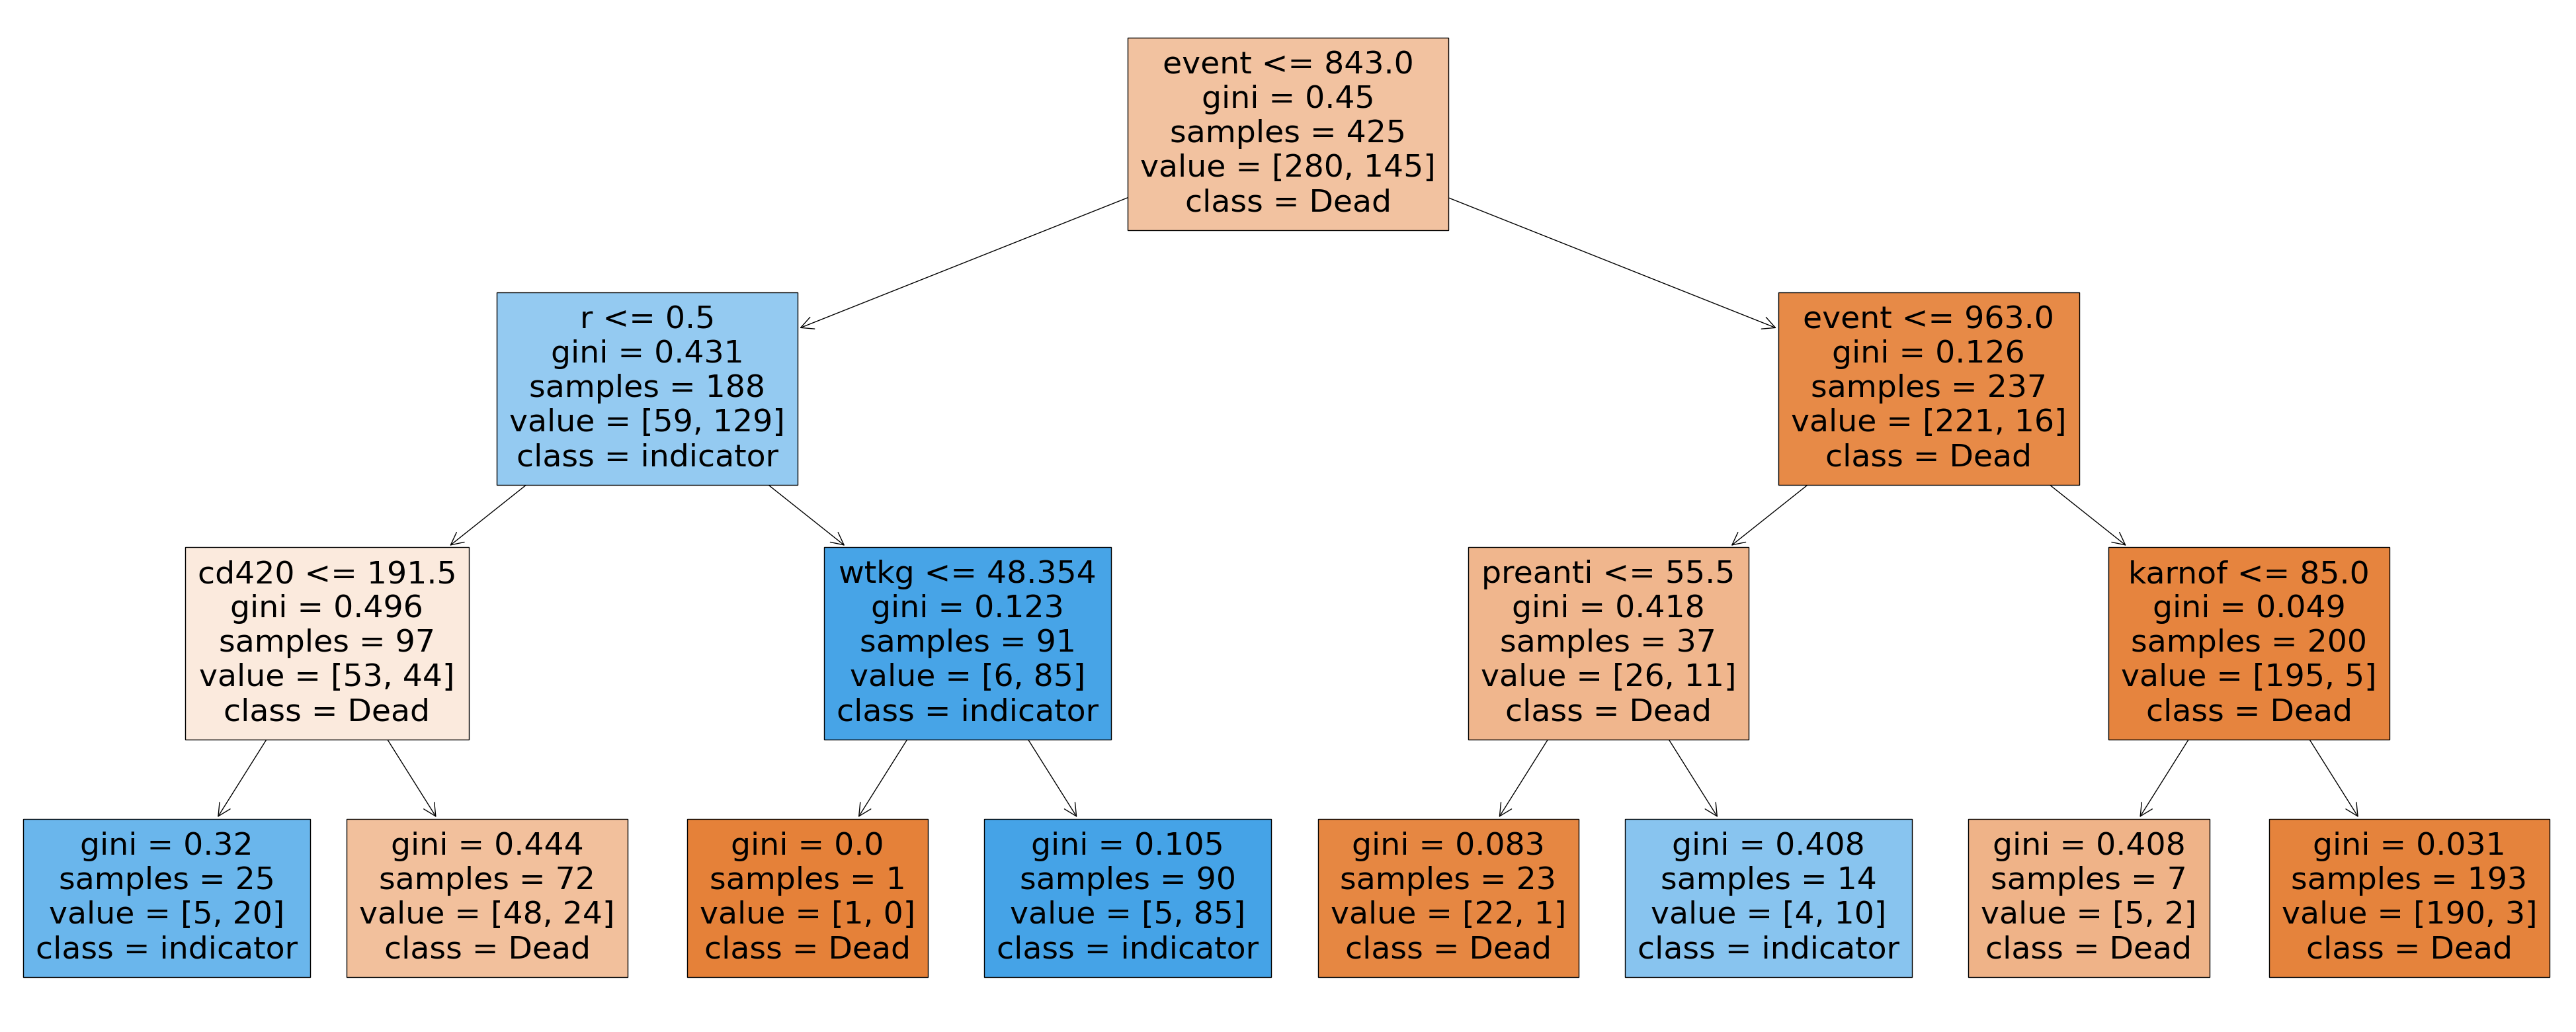

In [112]:
tree.plot_tree(model, filled=True, feature_names=X.columns, class_names= ['Dead', 'indicator'])
plt.rcParams['figure.figsize'] = [50,20]

In [131]:
model = RandomForestClassifier(criterion='gini', random_state=0)
grid = dict()
grid['max_depth'] = range(2,10)
grid['n_estimators'] = range(50,300,25)
model = GridSearchCV(model, grid, scoring='f1')
model.fit(X.iloc[train_idx], Y.iloc[train_idx])

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': range(2, 10),
                         'n_estimators': range(50, 300, 25)},
             scoring='f1')

In [133]:
best_params = model.best_params_

In [134]:
model.best_score_

0.8246829880728186

In [135]:
model = RandomForestClassifier(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'], criterion='gini',oob_score=True)
model.fit(X.iloc[train_idx], Y.iloc[train_idx])

RandomForestClassifier(max_depth=8, n_estimators=75, oob_score=True)

In [126]:
y_pre_test = model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum())) 
print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))

Test Confusion Matrix
[[66  5]
 [11 25]]
TesT Acc : 0.8504672897196262
Test F1-Score : 0.7575757575757577


In [128]:
feature_map = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score  Feature
0   0.318995    event
1   0.124171    cd420
2   0.116164    cd496
3   0.061977     cd80
4   0.058080     cd40
5   0.054445     wtkg
6   0.051847      age
7   0.043072  preanti
8   0.039545        r
9   0.038699    cd820
10  0.019982     race
11  0.012128   karnof
12  0.009896    strat
13  0.009469  symptom
14  0.007022    drugs
15  0.006799   gender
16  0.006438     homo
17  0.006425     hemo
18  0.006315      z30
19  0.006020     str2
20  0.002510   oprior
21  0.000000   zprior


In [137]:
feature_map = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score  Feature
0   0.363715    event
1   0.112202    cd496
2   0.106505    cd420
3   0.054514     wtkg
4   0.050290      age
5   0.049650        r
6   0.047861     cd80
7   0.047351     cd40
8   0.040643    cd820
9   0.036803  preanti
10  0.019199     race
11  0.013890   karnof
12  0.008759    strat
13  0.008152  symptom
14  0.007800   gender
15  0.007444    drugs
16  0.006385      z30
17  0.006104     hemo
18  0.005657     str2
19  0.004904     homo
20  0.002173   oprior
21  0.000000   zprior


In [139]:
print(model.oob_score_)

0.8847058823529412


In [142]:
print(model.oob_decision_function_)

[[0.98316498 0.01683502]
 [0.27030308 0.72969692]
 [0.86353291 0.13646709]
 [0.08805419 0.91194581]
 [0.91397849 0.08602151]
 [0.93722222 0.06277778]
 [0.27922078 0.72077922]
 [0.74074074 0.25925926]
 [0.90497137 0.09502863]
 [0.90158626 0.09841374]
 [1.         0.        ]
 [0.48244444 0.51755556]
 [0.93333333 0.06666667]
 [0.3967366  0.6032634 ]
 [0.09656375 0.90343625]
 [0.67290553 0.32709447]
 [0.51369565 0.48630435]
 [1.         0.        ]
 [0.46697575 0.53302425]
 [0.93769792 0.06230208]
 [0.70486347 0.29513653]
 [0.95657143 0.04342857]
 [0.97934473 0.02065527]
 [0.99781504 0.00218496]
 [0.97142857 0.02857143]
 [0.03602041 0.96397959]
 [0.14369048 0.85630952]
 [0.90064174 0.09935826]
 [0.56197157 0.43802843]
 [0.96296296 0.03703704]
 [0.98351648 0.01648352]
 [0.12087912 0.87912088]
 [0.29113872 0.70886128]
 [0.69617714 0.30382286]
 [0.06060606 0.93939394]
 [0.09544534 0.90455466]
 [0.74130435 0.25869565]
 [1.         0.        ]
 [0.98769231 0.01230769]
 [0.50822464 0.49177536]


In [147]:
metrics.roc_auc_score(Y[valid_idx], y_pre_test)

0.8120109546165885